In [1]:
from transformers import AutoTokenizer
from layoutlmft.models.layoutlmv3.tokenization_layoutlmv3_fast import LayoutLMv3TokenizerFast
import pyarrow

tokenizer = AutoTokenizer.from_pretrained(
    "layoutlmv3-base-1028",
    use_fast=True,
)

from datasets import load_dataset
cord = load_dataset("layoutlmft/data/cord_ner.py", name='default', )
cord_train = cord["train"]
cord_test = cord["test"]
cord_val = cord["validation"]
sroie = load_dataset("layoutlmft/data/sroie_ner.py", name='default')
sroie_train = sroie["train"]
sroie_test = sroie["test"]

import os
cord_id2label = {}
with open(os.path.join('RO-Datasets', 'CORD', 'labels_bio.txt')) as f:
    labels = f.read().splitlines()
    for i, label in enumerate(labels):
        cord_id2label[i] = label

sroie_id2label = {}
with open(os.path.join('RO-Datasets', 'SROIE', 'labels_bio.txt')) as f:
    labels = f.read().splitlines()
    for i, label in enumerate(labels):
        sroie_id2label[i] = label

/root/mambaforge/envs/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 0 examples [00:00, ? examples/s]An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/root/mambaforge/envs/env/lib/python3.8/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/root/mambaforge/envs/env/lib/python3.8/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
Generating train split: 626 examples [03:44,  2.79 examples/s]
Generating test split: 347 examples [02:09,  2.68 examples/s]


In [3]:
print([len(cord_train), len(cord_test), len(cord_val), len(sroie_train), len(sroie_test)])


NameError: name 'sroie_train' is not defined

In [8]:
cord_train[222]['bboxes']
cord_test[34]['bboxes']

[[18, 653, 81, 677],
 [87, 653, 190, 677],
 [200, 653, 328, 677],
 [334, 653, 431, 679],
 [478, 653, 518, 677],
 [781, 652, 906, 676],
 [15, 677, 109, 703],
 [121, 677, 250, 705],
 [290, 676, 325, 705],
 [793, 677, 909, 705],
 [3, 730, 171, 753],
 [796, 730, 925, 754],
 [6, 753, 103, 782],
 [121, 754, 225, 782],
 [818, 754, 921, 782],
 [0, 809, 100, 833],
 [803, 814, 931, 839],
 [-3, 862, 106, 891],
 [793, 870, 946, 895],
 [0, 892, 131, 919],
 [828, 900, 950, 923]]

In [7]:
# check if all bounding boxes are of elements that are not smaller than 0, no bigger than 1024
def check_bboxes(dataset):
    for i, example in enumerate(dataset):
        for j, bbox in enumerate(example['bboxes']):
            if any([coord < 0 or coord > 1024 for coord in bbox]):
                print(example['image_path'])
check_bboxes(cord_train)
check_bboxes(cord_test)

RO-Datasets/CORD/images/train_0222.png
RO-Datasets/CORD/images/train_0222.png
RO-Datasets/CORD/images/train_0222.png
RO-Datasets/CORD/images/test_0034.png


In [4]:
# manual check
import json
cord_train_idx = 0
cord_train_sample = cord_train[cord_train_idx]
cord_train_sample['ner_tags'] = [cord_id2label[label] for label in cord_train_sample['ner_tags']]
json.dump(cord_train_sample, open("cord_train_sample.json", "w"))

sroie_train_idx = 0
sroie_train_sample = sroie_train[sroie_train_idx]
sroie_train_sample['ner_tags'] = [sroie_id2label[label] for label in sroie_train_sample['ner_tags']]
json.dump(sroie_train_sample, open("sroie_train_sample.json", "w"))


In [ ]:
from layoutlmft.data.image_utils import RandomResizedCropAndInterpolationWithTwoPic, pil_loader, Compose

from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from torchvision import transforms
import torch
imagenet_default_mean_and_std = False
mean = IMAGENET_INCEPTION_MEAN if not imagenet_default_mean_and_std else IMAGENET_DEFAULT_MEAN
std = IMAGENET_INCEPTION_STD if not imagenet_default_mean_and_std else IMAGENET_DEFAULT_STD
common_transform = Compose([
    # transforms.ColorJitter(0.4, 0.4, 0.4),
    # transforms.RandomHorizontalFlip(p=0.5),
    RandomResizedCropAndInterpolationWithTwoPic(
        size=224, interpolation="bicubic"),
])
patch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=torch.tensor(mean),
        std=torch.tensor(std))
])
label_to_id = {i: i for i in range(7)}
# Tokenize all texts and align the labels with them.
def tokenize_and_align_labels_ner(examples, augmentation=False):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        padding=False,
        truncation=True,
        return_overflowing_tokens=True,
        # We use this argument because the texts in our dataset are lists of words (with a label for each word).
        is_split_into_words=True,
    )

    labels = []
    bboxes = []
    images = []
    ro_attns = []
    for batch_index in range(len(tokenized_inputs["input_ids"])):
        word_ids = tokenized_inputs.word_ids(batch_index=batch_index)
        org_batch_index = tokenized_inputs["overflow_to_sample_mapping"][batch_index]
        assert batch_index == org_batch_index

        # read order
        if True:
            ro_attn = [[0] * len(word_ids) for _ in range(len(word_ids))]
            ro_span = examples["ro_spans"][batch_index]
            head_start_words, head_end_words, tail_start_words, tail_end_words = ro_span["head_start"], ro_span["head_end"], ro_span["tail_start"], ro_span["tail_end"]
            for head_start_word, head_end_word, tail_start_word, tail_end_word in zip(head_start_words, head_end_words, tail_start_words, tail_end_words):
                head_start_token = head_end_token = tail_start_token = tail_end_token = None
                for token_idx, word_idx in enumerate(word_ids):
                    if word_idx == head_start_word and head_start_token is None:
                        head_start_token = token_idx
                    if word_idx == head_end_word and head_end_token is None:
                        head_end_token = token_idx
                    if word_idx == tail_start_word and tail_start_token is None:
                        tail_start_token = token_idx
                    if word_idx == tail_end_word and tail_end_token is None:
                        tail_end_token = token_idx
                assert head_start_token is not None and tail_start_token is not None
                if head_end_token is None:
                    head_end_token = len(word_ids) - 1
                if tail_end_token is None:
                    tail_end_token = len(word_ids) - 1
                for i in range(head_start_token, head_end_token):
                    for j in range(tail_start_token, tail_end_token):
                        ro_attn[i][j] = 1
            ro_attns.append(ro_attn)
        
        label = examples["ner_tags"][org_batch_index]
        bbox = examples["bboxes"][org_batch_index]
        previous_word_idx = None
        label_ids = []
        bbox_inputs = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
                bbox_inputs.append([0, 0, 0, 0])
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
                bbox_inputs.append(bbox[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label_to_id[label[word_idx]] if False else -100)
                bbox_inputs.append(bbox[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
        bboxes.append(bbox_inputs)

        if True:
            ipath = examples["image_path"][org_batch_index]
            img = pil_loader(ipath)
            for_patches, _ = common_transform(img, augmentation=augmentation)
            patch = patch_transform(for_patches)
            images.append(patch)

    tokenized_inputs["labels"] = labels
    tokenized_inputs["bbox"] = bboxes
    if True:
        tokenized_inputs["ro_attn"] = ro_attns
    if True:
        tokenized_inputs["images"] = images
    tokenized_inputs["image_path"] = examples["image_path"]

    return tokenized_inputs

# Tokenize all texts and align the start/end indices to the tokenizer
def tokenize_and_align_start_end_re(examples, augmentation=False):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        padding=False,
        truncation=True,
        return_overflowing_tokens=True,
        # We use this argument because the texts in our dataset are lists of words (with a label for each word).
        is_split_into_words=True,
    )
    bboxes = []
    images = []
    entities = []
    ro_attns = []
    batch_size = len(tokenized_inputs["input_ids"])
    for batch_index in range(batch_size):
        word_ids = tokenized_inputs.word_ids(batch_index=batch_index)
        ro_attn = [[0] * len(word_ids) for _ in range(len(word_ids))]
        start_word_idxs = examples["entities"][batch_index]["start"]
        end_word_idxs = examples["entities"][batch_index]["end"]
        aligned_start_word_idxs = []
        aligned_end_word_idxs = []
        bbox = examples["bboxes"][batch_index]
        previous_word_idx = None
        # read order
        if True:
            ro_span = examples["ro_spans"][batch_index]
            head_start_words, head_end_words, tail_start_words, tail_end_words = ro_span["head_start"], ro_span["head_end"], ro_span["tail_start"], ro_span["tail_end"]
            for head_start_word, head_end_word, tail_start_word, tail_end_word in zip(head_start_words, head_end_words, tail_start_words, tail_end_words):
                head_start_token = head_end_token = tail_start_token = tail_end_token = None
                for token_idx, word_idx in enumerate(word_ids):
                    if word_idx == head_start_word and head_start_token is None:
                        head_start_token = token_idx
                    if word_idx == head_end_word and head_end_token is None:
                        head_end_token = token_idx
                    if word_idx == tail_start_word and tail_start_token is None:
                        tail_start_token = token_idx
                    if word_idx == tail_end_word and tail_end_token is None:
                        tail_end_token = token_idx
                assert head_start_token is not None and tail_start_token is not None
                if head_end_token is None:
                    head_end_token = len(word_ids) - 1
                if tail_end_token is None:
                    tail_end_token = len(word_ids) - 1
                for i in range(head_start_token, head_end_token):
                    for j in range(tail_start_token, tail_end_token):
                        ro_attn[i][j] = 1
            ro_attns.append(ro_attn)
        # Outer loop: for every entity(bbox_inputs has the same outcome every loop, but to keep the code clean, we put it here)
        for start_word_idx, end_word_idx in zip(start_word_idxs, end_word_idxs):
            bbox_inputs = []
            start_token_idx = None
            end_token_idx = None
            # Inner loop: one pass word_ids to find the start/end token idx(end token idx is the first token of the next word)
            for token_idx, word_idx in enumerate(word_ids):
                # Special tokens have a word id that is None.
                if word_idx is None:
                    bbox_inputs.append([0, 0, 0, 0])
                # the first token of each word.
                elif word_idx != previous_word_idx:
                    bbox_inputs.append(bbox[word_idx])
                    if word_idx == start_word_idx:
                        start_token_idx = token_idx
                    if word_idx == end_word_idx:
                        end_token_idx = token_idx
                else:
                    bbox_inputs.append(bbox[word_idx])
                previous_word_idx = word_idx
            assert start_token_idx is not None
            if end_token_idx is None:
                end_token_idx = len(word_ids) - 1 # -1 because the last token is a special token
            aligned_start_word_idxs.append(start_token_idx)
            aligned_end_word_idxs.append(end_token_idx)
            
        bboxes.append(bbox_inputs)
        entities.append({
            "start": aligned_start_word_idxs,
            "end": aligned_end_word_idxs,
            "label": examples["entities"][batch_index]["label"],
        })
        if True:
            ipath = examples["image_path"][batch_index]
            img = pil_loader(ipath)
            for_patches, _ = common_transform(img, augmentation=augmentation)
            patch = patch_transform(for_patches)
            images.append(patch)
    tokenized_inputs["bbox"] = bboxes
    tokenized_inputs["entities"] = entities
    tokenized_inputs["relations"] = examples["relations"]
    # dummy labels because the trainer needs them
    tokenized_inputs["labels"] = [10000] * batch_size
    if True:
        tokenized_inputs["ro_attn"] = ro_attns
    if True:
        tokenized_inputs["images"] = images
    return tokenized_inputs

In [ ]:
cord_train_mapped = cord_train.map(tokenize_and_align_labels_ner, batched=True, remove_columns=cord_train.column_names, batch_size=1)
cord_test_mapped = cord_train.map(tokenize_and_align_labels_ner, batched=True, remove_columns=cord_train.column_names, batch_size=1)

In [6]:
cord_example2 = cord_train[0]
tokenization = tokenizer(cord_example2["tokens"], padding=False, truncation=True, return_overflowing_tokens=True, is_split_into_words=True)
word_ids = tokenization.word_ids(0)
cnt=0
for head_start_word, head_end_word, tail_start_word, tail_end_word in zip(cord_example2["ro_spans"]["head_start"], cord_example2["ro_spans"]["head_end"], cord_example2["ro_spans"]["tail_start"], cord_example2["ro_spans"]["tail_end"]):
    head_start_token = head_end_token = tail_start_token = tail_end_token = None
    for token_idx, word_idx in enumerate(word_ids):
        if word_idx == head_start_word and head_start_token is None:
            head_start_token = token_idx
        if word_idx == head_end_word and head_end_token is None:
            head_end_token = token_idx
        if word_idx == tail_start_word and tail_start_token is None:
            tail_start_token = token_idx
        if word_idx == tail_end_word and tail_end_token is None:
            tail_end_token = token_idx
    assert head_start_token is not None and tail_start_token is not None
    if head_end_token is None:
        head_end_token = len(word_ids) - 1
    if tail_end_token is None:
        tail_end_token = len(word_ids) - 1
    for i in range(head_start_token, head_end_token):
        for j in range(tail_start_token, tail_end_token):
            cnt+=1
            print(i, j)
print(cnt)

1 3
1 4
1 5
1 6
1 7
1 8
2 3
2 4
2 5
2 6
2 7
2 8
1 12
1 13
2 12
2 13
3 9
3 10
3 11
4 9
4 10
4 11
5 9
5 10
5 11
6 9
6 10
6 11
7 9
7 10
7 11
8 9
8 10
8 11
3 14
3 15
3 16
3 17
3 18
3 19
3 20
4 14
4 15
4 16
4 17
4 18
4 19
4 20
5 14
5 15
5 16
5 17
5 18
5 19
5 20
6 14
6 15
6 16
6 17
6 18
6 19
6 20
7 14
7 15
7 16
7 17
7 18
7 19
7 20
8 14
8 15
8 16
8 17
8 18
8 19
8 20
9 21
9 22
9 23
10 21
10 22
10 23
11 21
11 22
11 23
12 14
12 15
12 16
12 17
12 18
12 19
12 20
13 14
13 15
13 16
13 17
13 18
13 19
13 20
12 24
12 25
13 24
13 25
14 21
14 22
14 23
15 21
15 22
15 23
16 21
16 22
16 23
17 21
17 22
17 23
18 21
18 22
18 23
19 21
19 22
19 23
20 21
20 22
20 23
14 26
14 27
14 28
14 29
14 30
15 26
15 27
15 28
15 29
15 30
16 26
16 27
16 28
16 29
16 30
17 26
17 27
17 28
17 29
17 30
18 26
18 27
18 28
18 29
18 30
19 26
19 27
19 28
19 29
19 30
20 26
20 27
20 28
20 29
20 30
21 31
21 32
21 33
22 31
22 32
22 33
23 31
23 32
23 33
24 26
24 27
24 28
24 29
24 30
25 26
25 27
25 28
25 29
25 30
24 34
24 35
25 34
25 35
26 31

In [ ]:
print(list(enumerate(cord_example2["tokens"])))
print(cord_example2["ro_spans"]["head_start"])
print(cord_example2["ro_spans"]["head_end"])
print(cord_example2["ro_spans"]["tail_start"])
print(cord_example2["ro_spans"]["tail_end"])
print(list(enumerate(word_ids)))

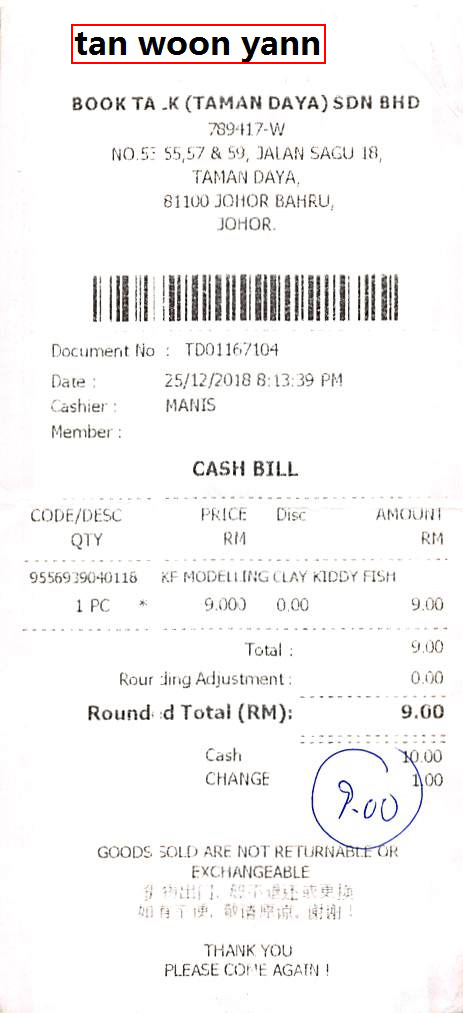

In [9]:
from PIL import ImageDraw
from PIL import Image

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def draw_boxes(image, boxes, color='red', width=2):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(unnormalize_box(box, image.width, image.height), outline=color, width=width)
        break
    return image

# plot_example = cord_train[0]
plot_example = sroie_train[0]
image = Image.open(plot_example['image_path'])
draw_boxes(image, plot_example['bboxes']).show()

In [ ]:
from layoutlmft.models.layoutlmv3.modeling_layoutlmv3 import LayoutLMv3ForTokenClassification
trained_model = LayoutLMv3ForTokenClassification.from_pretrained(
    "results/layoutlmv3-base-finetuned-custom-ner"
)

In [ ]:
example2_mapped = cord_train_mapped[30]
trained_model.eval()
from layoutlmft.data.data_collator import DataCollatorForKeyValueExtraction
collator = DataCollatorForKeyValueExtraction(tokenizer, max_length=1024, padding="max_length")
batch = collator([example2_mapped])
output = trained_model(
    input_ids=batch["input_ids"],
    bbox=batch["bbox"],
    attention_mask=batch["attention_mask"],
    ro_attn=batch["ro_attn"],
    labels=batch["labels"],
    images=batch["images"],
    return_dict=True,
)

In [ ]:
trained_model.eval()
from layoutlmft.data.data_collator import DataCollatorForKeyValueExtraction
from torch.utils.data import DataLoader
collator = DataCollatorForKeyValueExtraction(tokenizer, max_length=1024, padding="max_length")
loader = DataLoader(cord_test_mapped, batch_size=50, collate_fn=collator)
batch = next(iter(loader))
output = trained_model(
    input_ids=batch["input_ids"],
    bbox=batch["bbox"],
    attention_mask=batch["attention_mask"],
    ro_attn=batch["ro_attn"],
    labels=batch["labels"],
    images=batch["images"],
    return_dict=True,
)

In [ ]:
pred = [label_id_to_name[l.item()] for i, l in enumerate(torch.argmax(output[1][0], -1)) if batch["labels"][0][i] != -100]
labels = [label_id_to_name[l.item()] for l in batch["labels"][0] if l != -100]

In [ ]:
print(list(enumerate(pred)))
print(list(enumerate(labels)))

In [ ]:
from layoutlmft.trainer.trainer import ROTrainingArguments
train_args = ROTrainingArguments(output_dir=".")

In [ ]:
train_args.lam_lr